In [12]:
%%capture
import sklearn
import scikits.samplerate
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.online.coordinator import OnlineCoordinator
from braindecode.online.model import OnlineModel
from braindecode.online.data_processor import StandardizeProcessor

from braindecode.veganlasagne.layer_util import print_layers

from braindecode.datasets.loaders import BBCIDataset
from braindecode.veganlasagne.layers import transform_to_normal_net
from braindecode.mywyrm.processing import create_cnt_y

import lasagne
from braindecode.experiments.load import load_exp_and_model

In [14]:
import logging
log = logging.getLogger()
log.setLevel('DEBUG')

In [15]:
! find /home/schirrmr/data/online/ -iname '*03-15*'

/home/schirrmr/data/online/hawe/2017-03-15
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_10-55-25.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_10-04-53.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_10-40-16.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_11-40-05.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_11-26-44.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_11-09-11.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_12-46-44.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_14-31-57.npy
/home/schirrmr/data/online/hawe/2017-03-15/2017-03-15_14-46-19.npy


In [16]:
from glob import glob
all_set_filenames = sorted(glob('data/online/hawe/2017-03-15/*.npy'))
all_sets = [np.load(filename) for filename in all_set_filenames]
# create very small set for quick tests
all_sets = all_sets[3:4]
all_sets[0] = all_sets[0][:25000]

In [17]:
from braindecode.experiments.load import load_exp_and_model
import lasagne
exp, model = load_exp_and_model('data/models/online/cnt/hawe/14')

# make sure also exp final layer has new values
# since it is used by trainer
lasagne.layers.set_all_param_values(exp.final_layer, lasagne.layers.get_all_param_values(model))

INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 239
INFO:braindecode.experiments.experiment:Input window length is 522
INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 239
INFO:braindecode.experiments.experiment:Input window length is 522


In [18]:
from braindecode.online.trainer import BatchWiseCntTrainer
from braindecode.online.trainer import NoTrainer

online_trainer = BatchWiseCntTrainer(exp, n_updates_per_break=5, batch_size=45,
                                learning_rate=1e-3, n_min_trials=8, trial_start_offset=125,
                                     break_start_offset=125, break_stop_offset=125, train_param_values=None,
                                    deterministic_training=False, add_breaks=True)
#online_trainer = NoTrainer()
online_model = OnlineModel(transform_to_normal_net(model))
data_proc = StandardizeProcessor(factor_new=1e-3)
coordinator = OnlineCoordinator(data_proc,online_model, online_trainer, pred_gap=50)

from braindecode.online.file_client import create_y_signal
from numpy.random import RandomState


### Go through all sets adaptively....

In [19]:
from braindecode.online.trainer import BatchWiseCntTrainer
from braindecode.online.trainer import NoTrainer
from braindecode.online.file_client import create_y_signal
from numpy.random import RandomState
import scipy.signal
from braindecode.datasets.generate_filterbank import filter_is_stable
from braindecode.veganlasagne.layers import set_input_window_length
from braindecode.online.coordinator import make_predictions_with_online_predictor

model_base_name = 'data/models/online/cnt/hawe/13'
new_input_time_length = 600
# make sure also exp final layer has new values
# since it is used by trainer

lowpass = False
trial_start_offset = 0#125
break_start_offset = 50#250
break_stop_offset = -50#-125
resample_to_100 = False
min_break_samples = 220
min_trial_samples = 120

exp, model = load_exp_and_model(model_base_name)
if new_input_time_length is not None:
    set_input_window_length(exp.final_layer, new_input_time_length)
    set_input_window_length(model, new_input_time_length)

lasagne.layers.set_all_param_values(exp.final_layer, lasagne.layers.get_all_param_values(model))
preproced_all_sets = np.copy(all_sets)
if lowpass:
    fs = 250.0
    nyq_freq = 0.5 * fs
    high_cut_hz = 40.0
    high = high_cut_hz / nyq_freq
    filt_order = 10

    b, a = scipy.signal.butter(filt_order, high, btype='lowpass')

    assert filter_is_stable(a)

    for i_set in xrange(len(preproced_all_sets)):
        # [:-1] -> preprocess only sensors, not markers
        this_set = preproced_all_sets[i_set][:,:-1]
        filtered = scipy.signal.lfilter(b,a,this_set,axis=0)
        preproced_all_sets[i_set][:,:-1] = filtered
if resample_to_100:
    fs = 250.0
    for i_set in xrange(len(preproced_all_sets)):
        # [:-1] -> preprocess only sensors, not markers
        this_set = preproced_all_sets[i_set][:,:-1]
        resampled = scikits.samplerate.resample(this_set, 100.0/float(fs), 
            type='sinc_fastest')
        resampled_markers = scikits.samplerate.resample(preproced_all_sets[i_set][:,-1], 100.0/float(fs), 
            type='linear').astype(np.int32)
        new_set = np.concatenate((resampled, resampled_markers[:,np.newaxis]), axis=1)
        preproced_all_sets[i_set] = new_set

    

all_labels_per_set = []
all_preds_per_set = []
all_pred_samples_per_set = []
all_accs_per_set = []
n_min_trials = 4
add_old_data = True
learning_rate = 1e-4
add_breaks = True
keep_train_param_vals = True
old_train_param_vals = None
for i_set in range(len(preproced_all_sets)):
    online_trainer = BatchWiseCntTrainer(exp, n_updates_per_break=5, batch_size=45,
                                    learning_rate=learning_rate, n_min_trials=n_min_trials,
                                         trial_start_offset=trial_start_offset,
                                         break_start_offset=break_start_offset, 
                                         break_stop_offset=break_stop_offset,
                                         train_param_values=old_train_param_vals,
                                        deterministic_training=False, add_breaks=add_breaks,
                                         min_break_samples=min_break_samples, min_trial_samples=min_trial_samples,
                                        )
    #online_trainer = NoTrainer()
    old_samples_per_set = []
    old_markers_per_set = []
    if add_old_data and online_trainer.__class__.__name__ != 'NoTrainer':
         for i_set_before in range(i_set):
            old_samples_per_set.append(preproced_all_sets[i_set_before][:,:-1])
            old_markers_per_set.append(np.int32(preproced_all_sets[i_set_before][:,-1]))
    online_model = OnlineModel(transform_to_normal_net(model))
    data_proc = StandardizeProcessor(factor_new=1e-3)
    coordinator = OnlineCoordinator(data_proc,online_model, online_trainer, pred_gap=50)

    from braindecode.online.file_client import create_y_signal
    from numpy.random import RandomState
    block_len = 50
    input_start = 600
    cnt_data = preproced_all_sets[i_set][:,:-1]
    y = preproced_all_sets[i_set][:,-1]
    input_end = len(cnt_data) - 1
    i_pred_sample_arr, preds = make_predictions_with_online_predictor(coordinator, cnt_data, 
        y, block_len,
        input_start, input_end, old_samples_per_set, old_markers_per_set)

    from scipy import  interpolate
    interpolate_fn = interpolate.interp1d(i_pred_sample_arr, preds.T,
                                         bounds_error=False, fill_value=0)
    interpolated_preds = interpolate_fn(range(input_start,input_end))

    n_classes = 5

    y_labels = y
    y_label_reduced = y_labels[input_start:input_end]

    # also compute misclass:
    # set time with no markers to rest class
    # be aware these samples outside trials are ignored atm anyways
    interpolated_labels = y_label_reduced - 1
    interpolated_labels[interpolated_labels == -1] = 4

    interpolated_pred_labels = np.argmax(interpolated_preds, axis=0)
    label_pred_equal = interpolated_pred_labels == interpolated_labels
    label_pred_trial_equal = label_pred_equal[y_label_reduced!=0]
    samplewise_acc = np.mean(label_pred_equal)
    samplewise_acc_trial = np.mean(label_pred_trial_equal)
    print samplewise_acc, "samplewise accuracy total"
    print samplewise_acc_trial, "samplewise accuracy in trials"
    all_labels_per_set.append(y_labels)
    all_preds_per_set.append(preds)
    all_pred_samples_per_set.append(i_pred_sample_arr)
    all_accs_per_set.append(samplewise_acc)
    if keep_train_param_vals and online_trainer.__class__.__name__ != 'NoTrainer':
        old_train_param_vals = [p.get_value() for p in coordinator.trainer.train_params]
    
    

INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 239
INFO:braindecode.experiments.experiment:Input window length is 522
INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 239
INFO:braindecode.experiments.experiment:Input window length is 522
INFO:braindecode.online.trainer:Compile train function...
INFO:braindecode.veganlasagne.update_modifiers:Constraining time_conv to norm 2.00
INFO:braindecode.veganlasagne.update_modifiers:Constraining spat_conv to norm 2.00
INFO:braindecode.veganlasagne.update_modifiers:Constraining combined_conv_2 to norm 2.00
INFO:braindecode.veganlasagne.update_modifiers:Constraining combined_conv_3 to norm 2.00
INFO:braindecode.veganlasagne.update_modifiers:Constraining combined_conv_4 to norm 2.00
INFO:braindecode.veganlasagne.update_modifiers:Constraining final_dense to norm 2.00
INFO:braindecode.veganlasagne.update_modifiers:Constraining time_conv to norm 2.00
INFO:braindecode.veganlasagne.update_mo

0.571703758351 samplewise accuracy total
0.479801559178 samplewise accuracy in trials


In [ ]:
#with adaptation:
0.571703758351 samplewise accuracy total
0.479801559178 samplewise accuracy in trials

In [ ]:
#without adaptation:
0.49817615476 samplewise accuracy total
0.481612725411 samplewise accuracy in trials

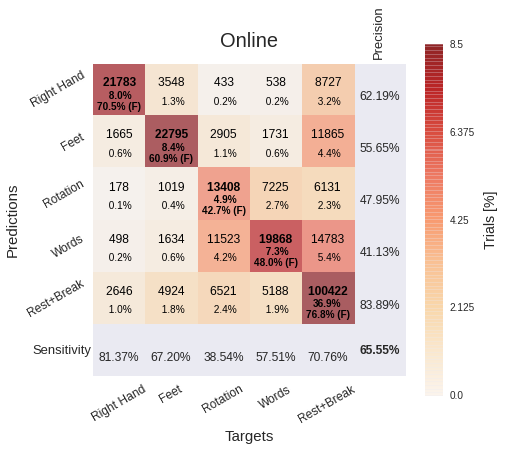

In [286]:

from braindecode.paper.plot import plot_conf_mat
from sklearn.metrics import confusion_matrix

conf_mats = [confusion_matrix(before_adapt_labels, before_adapt_preds)]


dummy_p_vals = np.ones(np.array(conf_mats[0].shape) + 1)
class_names = ['Right Hand',  'Feet', 'Rotation', 'Words', 'Rest+Break']
plot_conf_mat(np.sum(conf_mats, axis=0), dummy_p_vals, dummy_p_vals, "Online", class_names=class_names,
             figsize=(7,7),vmin=0,vmax=0.085, rotate_row_labels=30,
             rotate_col_labels=30, with_f1_score=True)

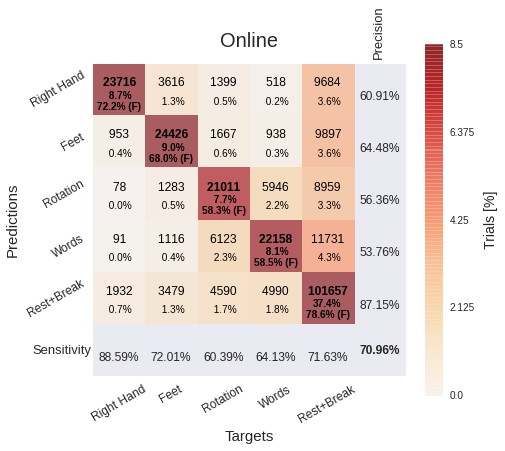

In [285]:

from braindecode.paper.plot import plot_conf_mat
from sklearn.metrics import confusion_matrix

conf_mats = [confusion_matrix(interpolated_labels, interpolated_pred_labels)]


dummy_p_vals = np.ones(np.array(conf_mats[0].shape) + 1)
class_names = ['Right Hand',  'Feet', 'Rotation', 'Words', 'Rest+Break']
plot_conf_mat(np.sum(conf_mats, axis=0), dummy_p_vals, dummy_p_vals, "Online", class_names=class_names,
             figsize=(7,7),vmin=0,vmax=0.085, rotate_row_labels=30,
             rotate_col_labels=30, with_f1_score=True)

In [247]:
#np.save('bef-adapt-130-to-delete.npy', before_adapt_correct)
#np.save('adapt-130-to-delete.npy', adapt_correct)

In [251]:
before_adapt_preds = interpolated_pred_labels.copy()
before_adapt_labels = interpolated_labels.copy()

In [256]:
%%javascript
function makeSVGDownloadable() {
    $('body').on('click', 'svg', function(){
        var svg = this.outerHTML;
        var b64 = btoa(svg); // or use btoa if supported
        var linkToSVG = $("<a href-lang='image/svg+xml' href='data:image/svg+xml;base64,\n" + b64 +
                          "'title='file.svg' target='blank'>Download</a>");
        $(this).after(linkToSVG);});
}
makeSVGDownloadable()

<IPython.core.display.Javascript object>

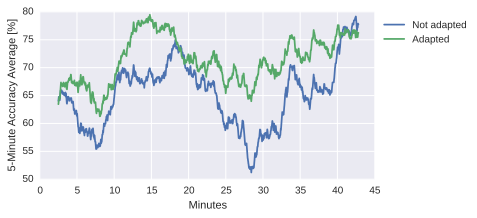

In [287]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(6,3))
before_adapt_correct = before_adapt_preds == before_adapt_labels
adapt_correct = interpolated_pred_labels == interpolated_labels
from braindecode.analysis.stats import running_mean

win_len = 30000
run_mean_before_adapt = running_mean(before_adapt_correct, window_len=win_len)
run_mean_adapt = running_mean(adapt_correct, window_len=win_len)


times = (np.arange(run_mean_adapt.shape[0]) / (100.0 * 60)) + (0.5 * win_len / (100.0 * 60))

plt.plot(times, run_mean_before_adapt * 100)
plt.plot(times,run_mean_adapt * 100)
plt.xlabel("Minutes")
plt.ylabel("5-Minute Accuracy Average [%]")
plt.legend(("Not adapted", "Adapted",), bbox_to_anchor=(1.3,1.))



###### this was with another model more training

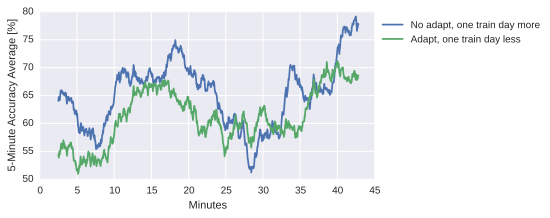

In [274]:

%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(6,3))
before_adapt_correct = before_adapt_preds == before_adapt_labels
adapt_correct = np.load('adapt-130-to-delete.npy')
from braindecode.analysis.stats import running_mean

win_len = 30000
run_mean_before_adapt = running_mean(before_adapt_correct, window_len=win_len)
run_mean_adapt = running_mean(adapt_correct, window_len=win_len)


times = (np.arange(run_mean_adapt.shape[0]) / (100.0 * 60)) + (0.5 * win_len / (100.0 * 60))

plt.plot(times, run_mean_before_adapt * 100)
plt.plot(times,run_mean_adapt * 100)
plt.xlabel("Minutes")
plt.ylabel("5-Minute Accuracy Average [%]")
plt.legend(("No adapt, one train day more", "Adapt, one train day less"), bbox_to_anchor=(1.52,1.))

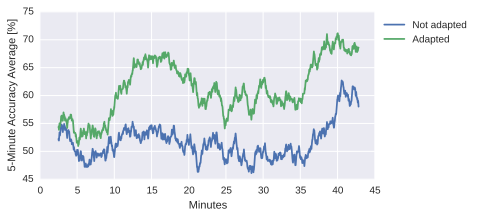

In [266]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(6,3))
before_adapt_correct = np.load('bef-adapt-130-to-delete.npy')
adapt_correct = np.load('adapt-130-to-delete.npy')
from braindecode.analysis.stats import running_mean

win_len = 30000
run_mean_before_adapt = running_mean(before_adapt_correct, window_len=win_len)
run_mean_adapt = running_mean(adapt_correct, window_len=win_len)


times = (np.arange(run_mean_adapt.shape[0]) / (100.0 * 60)) + (0.5 * win_len / (100.0 * 60))

plt.plot(times, run_mean_before_adapt * 100)
plt.plot(times,run_mean_adapt * 100)
plt.xlabel("Minutes")
plt.ylabel("5-Minute Accuracy Average [%]")
plt.legend(("Not adapted", "Adapted",), bbox_to_anchor=(1.3,1.))